In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import time
import pyodbc
print(pyodbc.drivers())
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
from scipy import stats

['SQL Server', 'ODBC Driver 17 for SQL Server', 'SQL Server Native Client RDA 11.0', 'Microsoft Access Driver (*.mdb, *.accdb)', 'Microsoft Excel Driver (*.xls, *.xlsx, *.xlsm, *.xlsb)', 'Microsoft Access Text Driver (*.txt, *.csv)', 'Microsoft Access dBASE Driver (*.dbf, *.ndx, *.mdx)']


# SQL Connection

In [2]:
def create_sql_connection(server, database, username, password, driver='{ODBC Driver 17 for SQL Server}'):
    """
    Establish a connection to a SQL Server database using pyodbc.

    Parameters:
    - server (str): The SQL Server address (e.g., 'localhost' or server IP).
    - database (str): The name of the database you want to connect to.
    - username (str): SQL Server username.
    - password (str): SQL Server password.
    - driver (str): ODBC driver to use. Default is '{ODBC Driver 17 for SQL Server}'.s

    Returns:
    - conn: A pyodbc connection object if successful.
    """
    connection_string = f"""
        DRIVER={driver};
        SERVER={server};
        DATABASE={database};
        UID={username};
        PWD={password};
    """
    try:
        conn = pyodbc.connect(connection_string)
        print("Connection established successfully!")
        return conn
    except Exception as e:
        print(f"Failed to connect to the database. Error: {e}")
        return None

In [3]:
def query_data(conn, query):
    """
    Execute a SQL query and fetch results as a pandas DataFrame.
    
    Parameters:
    - conn: A pyodbc connection object.
    - query (str): The SQL query to be executed.
    
    Returns:
    - df: A pandas DataFrame containing the query result.
    """
    start_time = time.time()  # Start time measurement
    try:
        cursor = conn.cursor()
        cursor.execute(query)
        
        # Fetch all results from the query
        rows = cursor.fetchall()
        
        # Get column names from cursor
        columns = [desc[0] for desc in cursor.description]
        
        # Create a pandas DataFrame from the results
        df = pd.DataFrame.from_records(rows, columns=columns)
        
    except pyodbc.Error as e:
        print(f"Error executing query: {e}")
        return None
    
    finally:
        cursor.close()
    
    end_time = time.time()  # End time measurement
    execution_time = end_time - start_time  # Calculate execution time
    
    # Print the DataFrame and execution time
    print(f"Query executed in: {execution_time:.4f} seconds")
    
    return df  

In [4]:
server = 'ROHIT'     
database = 'DiabetesData'  
username = 'rohit_kosamkar'       
password = 'September@2024' 

# Establish connection
conn = create_sql_connection(server, database, username, password)

Connection established successfully!


In [5]:
query = '''
select *, admissionsource.description as admission_source_des, admissiontype.description as admission_type_desc, discharge_disposition.description as discharge_desposition_desc 
from patient_data_train_test 
left join admissionsource on admissionsource.admission_source_id = patient_data_train_test.admission_source_id
left join discharge_disposition on discharge_disposition.discharge_disposition_id = patient_data_train_test.discharge_disposition_id
left join admissiontype on admissiontype.admission_type_id = patient_data_train_test.admission_type_id
left join patient_readmission_status on patient_readmission_status.encounter_id = patient_data_train_test.encounter_id'''

In [81]:
data_temp = query_data(conn, query)
data_temp.shape

Query executed in: 4.8661 seconds


(85000, 60)

In [82]:
data = data_temp.copy(deep=True)

# Data Cleaning

In [83]:
data.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide_metformin', 'glipizide_metformin',
       'glimepiride_pioglitazone', 'metformin_rosiglitazone',
       'metformin_pioglitazone', 'change', 'diabetesMed',
       'admission_source_id', 'description', 'discharge_disposition_id',
       'description', 'admission_

In [84]:
selected_col = ['encounter_id', 'patient_nbr','race', 'gender', 'age', 'weight',
       
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide_metformin', 'glipizide_metformin',
       'glimepiride_pioglitazone', 'metformin_rosiglitazone',
       'metformin_pioglitazone', 'change', 'diabetesMed',
        'readmitted',
       'admission_source_des', 'admission_type_desc',
       'discharge_desposition_desc']

In [85]:
data = data[selected_col].iloc[:,1:]

In [86]:
data.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide_metformin', 'glipizide_metformin',
       'glimepiride_pioglitazone', 'metformin_rosiglitazone',
       'metformin_pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'admission_source_des', 'admission_type_desc',
       'discharge_desposition_desc'],
      dtype='object')

In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85000 entries, 0 to 84999
Data columns (total 50 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   encounter_id                85000 non-null  int64 
 1   patient_nbr                 85000 non-null  int64 
 2   race                        85000 non-null  object
 3   gender                      85000 non-null  object
 4   age                         85000 non-null  object
 5   weight                      85000 non-null  object
 6   time_in_hospital            85000 non-null  int64 
 7   payer_code                  85000 non-null  object
 8   medical_specialty           85000 non-null  object
 9   num_lab_procedures          85000 non-null  int64 
 10  num_procedures              85000 non-null  int64 
 11  num_medications             85000 non-null  int64 
 12  number_outpatient           85000 non-null  int64 
 13  number_emergency            85000 non-null  in

In [88]:
data.describe()

,encounter_id,patient_nbr,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,8.500000e+04,8.500000e+04,85000.000000,85000.000000,85000.000000,85000.000000,85000.000000,85000.000000,85000.000000,85000.000000
mean,1.304736e+08,4.882462e+07,4.451612,43.300118,1.334894,15.861812,0.344929,0.178400,0.631271,7.279941
std,6.857767e+07,3.546755e+07,3.015638,19.260734,1.687531,8.129045,1.222098,0.827394,1.251215,1.959969
min,1.252200e+04,1.350000e+02,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,7.414607e+07,2.000563e+07,2.000000,32.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.310813e+08,4.240574e+07,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,1.774056e+08,8.487709e+07,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,2.687621e+08,1.152185e+08,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,9.000000


In [89]:
data.isnull().sum()

encounter_id                      0
patient_nbr                       0
race                              0
gender                            0
age                               0
weight                            0
time_in_hospital                  0
payer_code                        0
medical_specialty                 0
num_lab_procedures                0
num_procedures                    0
num_medications                   0
number_outpatient                 0
number_emergency                  0
number_inpatient                  0
diag_1                            0
diag_2                            0
diag_3                            0
number_diagnoses                  0
max_glu_serum                 79857
A1Cresult                     70951
metformin                         0
repaglinide                       0
nateglinide                       0
chlorpropamide                    0
glimepiride                       0
acetohexamide                     0
glipizide                   

In [90]:
# data.drop(columns={'max_glu_serum', 'A1Cresult'},inplace=True)
data['max_glu_serum'] = data['max_glu_serum'].fillna('No')
data['A1Cresult'] = data['A1Cresult'].fillna('No')

In [91]:
data.shape

(85000, 50)

In [92]:
data['number_emergency'] = data['number_emergency'].fillna(0)

In [93]:
data.isnull().sum()

encounter_id                  0
patient_nbr                   0
race                          0
gender                        0
age                           0
weight                        0
time_in_hospital              0
payer_code                    0
medical_specialty             0
num_lab_procedures            0
num_procedures                0
num_medications               0
number_outpatient             0
number_emergency              0
number_inpatient              0
diag_1                        0
diag_2                        0
diag_3                        0
number_diagnoses              0
max_glu_serum                 0
A1Cresult                     0
metformin                     0
repaglinide                   0
nateglinide                   0
chlorpropamide                0
glimepiride                   0
acetohexamide                 0
glipizide                     0
glyburide                     0
tolbutamide                   0
pioglitazone                  0
rosiglit

In [94]:
# Check for unique values in categorical columns
categorical_columns = data.select_dtypes(include=['object']).columns
print(len(categorical_columns))
for col in categorical_columns:
    print(f"{col}: {data[col].unique()}")


40
race: ['Caucasian' 'AfricanAmerican' '?' 'Other' 'Asian' 'Hispanic']
gender: ['Female' 'Male' 'Unknown/Invalid']
age: ['[80-90)' '[90-100)' '[40-50)' '[50-60)' '[60-70)' '[70-80)' '[20-30)'
 '[10-20)' '[30-40)' '[0-10)']
weight: ['?' '[75-100)' '[50-75)' '[0-25)' '[100-125)' '[25-50)' '[125-150)'
 '[175-200)' '[150-175)' '>200']
payer_code: ['?' 'MC' 'MD' 'HM' 'UN' 'BC' 'SP' 'CP' 'SI' 'DM' 'CM' 'CH' 'PO' 'WC' 'OT'
 'OG' 'MP']
medical_specialty: ['?' 'InternalMedicine' 'Family/GeneralPractice' 'Cardiology'
 'Surgery-General' 'Orthopedics' 'Gastroenterology'
 'Surgery-Cardiovascular/Thoracic' 'Nephrology'
 'Orthopedics-Reconstructive' 'Pediatrics-Endocrinology' 'Psychiatry'
 'Emergency/Trauma' 'Pulmonology' 'Surgery-Neuro'
 'Obsterics&Gynecology-GynecologicOnco' 'ObstetricsandGynecology'
 'Pediatrics' 'Hematology/Oncology' 'Otolaryngology'
 'Surgery-Colon&Rectal' 'Pediatrics-CriticalCare' 'Endocrinology'
 'Urology' 'Psychiatry-Child/Adolescent' 'Pediatrics-Pulmonology'
 'Neurology' 'A

In [95]:
data['race'].value_counts()

race
Caucasian          63153
AfricanAmerican    16989
?                   1796
Hispanic            1558
Other               1066
Asian                438
Name: count, dtype: int64

In [96]:
# race (~2k values replaced with 'Other' category)
data['race'] = data['race'].replace('?','Other')
data['race'].value_counts()

race
Caucasian          63153
AfricanAmerican    16989
Other               2862
Hispanic            1558
Asian                438
Name: count, dtype: int64

In [97]:
# gender (Only 3 values with "Unknown/Invalid" entry replacing it with the 'Female' as female proportion in the dataset is on higher side)

data['gender'] = data['gender'].replace('Unknown/Invalid', 'Female')
data['gender'].value_counts()

gender
Female    45813
Male      39187
Name: count, dtype: int64

In [98]:
data['admission_type_desc'].value_counts()

admission_type_desc
Emergency        43691
Urgent           16026
Elective         15349
NULL              4888
Not Available     4761
Not Mapped         264
Trauma Center       13
Newborn              8
Name: count, dtype: int64

In [99]:
# # admission_type_description -  Contains 4785 Null values, replacing it with the existing category "Not Available". Also Not Mapped replace with same category 
# data['admission_type_desc'].value_counts(dropna=False)
# data['admission_type_desc'] = data['admission_type_desc'].fillna('Other').replace({'Not Mapped': 'Not Available','NULL': 'Not Available'})
# data['admission_type_desc'].value_counts(dropna=False)

In [100]:
pd.crosstab(data['admission_type_desc'], data['readmitted'])

readmitted,NO,YES
admission_type_desc,,
Elective,8737,6612
Emergency,22414,21277
NULL,2201,2687
Newborn,5,3
Not Available,2550,2211
Not Mapped,164,100
Trauma Center,13,0
Urgent,8449,7577


In [101]:
# Admission Type categories
admission_type_other_categories = ['Trauma Center', 'Newborn','NULL','Not Available','Not Mapped']

# Replacing admission type categories with 'Other'
data['admission_type_desc'] = data['admission_type_desc'].apply(
    lambda x: 'Other' if x in admission_type_other_categories else x
)

data['admission_type_desc'].value_counts()

admission_type_desc
Emergency    43691
Urgent       16026
Elective     15349
Other         9934
Name: count, dtype: int64

In [102]:
# discharge_disposition_description
data['discharge_desposition_desc'].value_counts(dropna= False)

discharge_desposition_desc
Discharged to home                                                                                           49888
Discharged/transferred to SNF                                                                                11305
Discharged/transferred to home with home health service                                                      10603
NULL                                                                                                          3683
Discharged/transferred to another short term hospital                                                         1812
Discharged/transferred to another rehab fac including rehab units of a hospital .                             1640
Expired                                                                                                       1411
Discharged/transferred to another type of inpatient care institution                                          1093
Not Mapped                                           

In [103]:
## making subcategories for the discharge disposition
discharge_categories = {
    #Discharged to Home
    'Discharged to home': 'Discharged to Home',
    'Discharged/transferred to home with home health service': 'Discharged to Home',
    'Discharged/transferred to home under care of Home IV provider': 'Discharged to Home',
    
    #Transfers to Other Healthcare Facilities
    'Discharged/transferred to SNF': 'Transfers to Other Healthcare Facilities',
    'Discharged/transferred to another short term hospital': 'Transfers to Other Healthcare Facilities',
    'Discharged/transferred to another rehab fac including rehab units of a hospital .': 'Transfers to Other Healthcare Facilities',
    'Discharged/transferred to another type of inpatient care institution': 'Transfers to Other Healthcare Facilities',
    'Discharged/transferred to ICF': 'Transfers to Other Healthcare Facilities',
    'Discharged/transferred to a long term care hospital.': 'Transfers to Other Healthcare Facilities',
    'Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital': 'Transfers to Other Healthcare Facilities',
    'Discharged/transferred to a federal health care facility.': 'Transfers to Other Healthcare Facilities',
    'Discharged/transferred within this institution to Medicare approved swing bed': 'Transfers to Other Healthcare Facilities',
    'Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.': 'Transfers to Other Healthcare Facilities',
    'Neonate discharged to another hospital for neonatal aftercare': 'Transfers to Other Healthcare Facilities',
    'Discharged/transferred/referred to this institution for outpatient services': 'Transfers to Other Healthcare Facilities',
    'Discharged/transferred/referred another institution for outpatient services': 'Transfers to Other Healthcare Facilities',

    #Expired
    'Expired': 'Expired',
    'Expired at home. Medicaid only, hospice.': 'Expired',
    'Expired in a medical facility. Medicaid only, hospice.': 'Expired',
    
    #Hospice Care
    'Hospice / home': 'Hospice Care',
    'Hospice / medical facility': 'Hospice Care',
    
    #AMA (Against Medical Advice)
    'Left AMA': 'AMA (Against Medical Advice)',
    
    #Other
    'Not Mapped': 'Other',
    'NaN':'Other',
    'Still patient or expected to return for outpatient services': 'Other',
    'Admitted as an inpatient to this hospital': 'Other',
    
    np.nan: 'Other'
}

 

In [104]:
# Expired type not in target
pd.crosstab(data['discharge_desposition_desc'].map(discharge_categories), data['readmitted'])


readmitted,NO,YES
discharge_desposition_desc,,
AMA (Against Medical Advice),255,262
Discharged to Home,31206,29393
Expired,1420,0
Hospice Care,501,62
Other,526,479
Transfers to Other Healthcare Facilities,8425,8788


In [105]:
data['discharge_category'] = data['discharge_desposition_desc'].map(discharge_categories).fillna('Other')
data['discharge_category'].value_counts(dropna=False)


discharge_category
Discharged to Home                          60599
Transfers to Other Healthcare Facilities    17213
Other                                        4688
Expired                                      1420
Hospice Care                                  563
AMA (Against Medical Advice)                  517
Name: count, dtype: int64

In [106]:
# admission_source_description

data['admission_source_des'].value_counts(dropna=False)

admission_source_des
Emergency Room                                               46289
Physician Referral                                           24902
NULL                                                          6514
Transfer from a hospital                                      2852
Transfer from another health care facility                    2157
Clinic Referral                                               1090
Transfer from a Skilled Nursing Facility (SNF)                 711
HMO Referral                                                   182
Not Mapped                                                     161
Not Available                                                  119
Court/Law Enforcement                                           10
Transfer from critial access hospital                            8
Extramural Birth                                                 2
Transfer from hospital inpt/same fac reslt in a sep claim        2
Normal Delivery                          

In [107]:
# ## making subcategories for the admission source 

admission_source_categories = {
    'Emergency Room': 'Emergency Admission',
    'Court/Law Enforcement': 'Emergency Admission',
    
    'Physician Referral': 'Physician Referral',
    'HMO Referral': 'Physician Referral',
    'Clinic Referral': 'Physician Referral',
    
    'Transfer from a hospital': 'Transfers from Other Facilities',
    'Transfer from another health care facility': 'Transfers from Other Facilities',
    'Transfer from a Skilled Nursing Facility (SNF)': 'Transfers from Other Facilities',
    'Transfer from hospital inpt/same fac reslt in a sep claim': 'Transfers from Other Facilities',
    'Transfer from critial access hospital': 'Transfers from Other Facilities',
    'Transfer from Ambulatory Surgery Center': 'Transfers from Other Facilities',
    
    'Extramural Birth': 'Other',
    'Normal Delivery': 'Other',
    'Sick Baby': 'Other',
    
    np.nan: 'Other',
    
    'Not Mapped': 'Other',
    'Not Available': 'Other'
}

In [108]:
data['admission_category'] = data['admission_source_des'].map(admission_source_categories).fillna('Other')
data['admission_category'].value_counts(dropna=False)

admission_category
Emergency Admission                46299
Physician Referral                 26174
Other                               6797
Transfers from Other Facilities     5730
Name: count, dtype: int64

In [109]:
pd.crosstab(data['admission_category'], data['readmitted'])


readmitted,NO,YES
admission_category,,
Emergency Admission,22522,23777
Other,3588,3209
Physician Referral,14449,11725
Transfers from Other Facilities,3974,1756


In [110]:
data['medical_specialty'].value_counts(dropna=False)

medical_specialty
?                                       38623
InternalMedicine                        13479
Family/GeneralPractice                   7025
Emergency/Trauma                         5892
Cardiology                               4865
Surgery-General                          2731
Nephrology                               1541
Orthopedics-Reconstructive               1199
Orthopedics                              1191
Psychiatry                                824
Pulmonology                               823
Urology                                   650
ObstetricsandGynecology                   640
Surgery-Cardiovascular/Thoracic           629
Radiologist                               616
Gastroenterology                          518
Surgery-Vascular                          509
Surgery-Neuro                             460
PhysicalMedicineandRehabilitation         389
Oncology                                  325
Pediatrics                                242
Hematology/Oncol

In [111]:
data['medical_specialty'].nunique()

70

In [112]:
speciality_mapping = {
    "Internal Medicine": [
        "Internal Medicine",
        "Hematology",
        "Infectious Diseases",
        "Nephrology",
        "Neurology",
        "Rheumatology",
        "Endocrinology",
        "Allergy and Immunology",
        "Psychiatry-Addictive",
        "Psychiatry-Child/Adolescent",
        "Psychiatry"
    ],
    "Cardiology": [
        "Cardiology",
        "Cardiology-Pediatric",
        "Surgery-Cardiovascular",
        "Surgery-Cardiovascular/Thoracic"
    ],
    "Surgery": [
        "Surgery-General",
        "Surgery-Neuro",
        "Surgery-Plastic",
        "Surgery-PlasticwithinHeadandNeck",
        "Surgery-Thoracic",
        "Surgery-Pediatric",
        "Surgery-Maxillofacial",
        "Surgery-Vascular",
        "SurgicalSpecialty",
        "Surgery-Colon&Rectal"
    ],
    "Family/General Practice": [
        "Family/General Practice",
        "Family/general practice",
        "Hospitalist",
        "PhysicianNotFound",
        "Resident",
        "DCPTEAM"
    ],
    "Other": [
        "Missing or unknown"
    ],
    "Other": [
        "Pediatrics-Endocrinology",
        "Gastroenterology",
        "Orthopedics",
        "Orthopedics-Reconstructive",
        "Emergency/Trauma",
        "Pulmonology",
        "Obstetrics and Gynecology",
        "Obstetrics and Gynecology-Gynecologic Onco",
        "Pediatrics-Critical Care",
        "Pediatrics-Pulmonology",
        "Anesthesiology-Pediatric",
        "Radiology",
        "Psychology",
        "Podiatry",
        "Gynecology",
        "Oncology",
        "Pediatrics-Neurology",
        "Ophthalmology",
        "Pediatrics-Emergency Medicine",
        "Physical Medicine and Rehabilitation",
        "Otolaryngology",
        "Pathology",
        "Dermatology",
        "Sports Medicine",
        "Speech",
        "Perinatology",
        "Neurophysiology",
        "Endocrinology-Metabolism",
        "Dentistry",
        "Osteopath",
        "Proctology",
        "Radiologist",
        "Surgeon"
    ]
}

In [113]:
# new column with 'Other' by default
data['Specialty_Group'] = 'Other'
 
# Handling missing Medical_Specialty
data['medical_specialty'] = data['medical_specialty'].replace('?', 'Missing or unknown')

In [114]:
# replacing with specialty mapping
for category, specialties in speciality_mapping.items():
        data.loc[data['medical_specialty'].isin(specialties), 'Specialty_Group'] = category

In [115]:
data['Specialty_Group'].value_counts(dropna=False)

Specialty_Group
Other                      72736
Cardiology                  5593
Surgery                     3879
Internal Medicine           2742
Family/General Practice       50
Name: count, dtype: int64

In [116]:
# deleting original column as no longer needed
del data['medical_specialty']

In [117]:
# Deleting columns examide and citoglipton as both columns has only "No" entry
print(data['citoglipton'].value_counts())
print(data['examide'].value_counts())

data.drop(columns={'examide', 'citoglipton'}, inplace=True)

citoglipton
No    85000
Name: count, dtype: int64
examide
No    85000
Name: count, dtype: int64


In [118]:
data.shape

(85000, 50)

In [119]:
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,time_in_hospital,payer_code,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesMed,readmitted,admission_source_des,admission_type_desc,discharge_desposition_desc,discharge_category,admission_category,Specialty_Group
0,12522,48330783,Caucasian,Female,[80-90),?,13,?,68,2,28,0,0,0,398,427,38,8,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO,Transfer from a hospital,Urgent,Discharged to home,Discharged to Home,Transfers from Other Facilities,Other
1,15738,63555939,Caucasian,Female,[90-100),?,12,?,33,3,18,0,0,0,434,198,486,8,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO,Transfer from a hospital,Elective,Discharged/transferred to SNF,Transfers to Other Healthcare Facilities,Transfers from Other Facilities,Other
2,16680,42519267,Caucasian,Male,[40-50),?,1,?,51,0,8,0,0,0,197,157,250,5,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO,Emergency Room,Emergency,Discharged to home,Discharged to Home,Emergency Admission,Other
3,28236,89869032,AfricanAmerican,Female,[40-50),?,9,?,47,2,17,0,0,0,250.7,403,996,9,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,YES,Emergency Room,Emergency,Discharged to home,Discharged to Home,Emergency Admission,Other
4,35754,82637451,Caucasian,Male,[50-60),?,3,?,31,6,16,0,0,0,414,411,250,9,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,YES,Clinic Referral,Urgent,Discharged to home,Discharged to Home,Physician Referral,Other


In [120]:
pd.crosstab(data['payer_code'],data['readmitted'])

readmitted,NO,YES
payer_code,,
?,20251,17762
BC,2097,1401
CH,42,22
CM,683,634
CP,1114,826
DM,200,223
HM,2484,2257
MC,12362,12657
MD,1244,1314


In [121]:
def map_payor_code(code):
    if code in ['BC', 'HM', 'SP', 'MD', 'MP']:
        return 'Private Insurance'
    elif code in ['MC', 'MD', 'CH', 'DM', 'CM']:
        return 'Government Programs'
    elif code in ['OG', 'PO', 'SI', 'WC', 'UN', 'OT']:
        return 'Self-Pay/Other'
    else:
        return 'Self-Pay/Other'

In [122]:
# let's applying map_payor_code function to the data
data['payer_code_group'] = data['payer_code'].apply(map_payor_code)
data['payer_code_group'].value_counts()


payer_code_group
Self-Pay/Other         43491
Government Programs    26823
Private Insurance      14686
Name: count, dtype: int64

In [123]:
# deleting original columns as no longer needed
del data['payer_code']

In [124]:
data.shape

(85000, 50)

In [125]:
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesMed,readmitted,admission_source_des,admission_type_desc,discharge_desposition_desc,discharge_category,admission_category,Specialty_Group,payer_code_group
0,12522,48330783,Caucasian,Female,[80-90),?,13,68,2,28,0,0,0,398,427,38,8,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO,Transfer from a hospital,Urgent,Discharged to home,Discharged to Home,Transfers from Other Facilities,Other,Self-Pay/Other
1,15738,63555939,Caucasian,Female,[90-100),?,12,33,3,18,0,0,0,434,198,486,8,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO,Transfer from a hospital,Elective,Discharged/transferred to SNF,Transfers to Other Healthcare Facilities,Transfers from Other Facilities,Other,Self-Pay/Other
2,16680,42519267,Caucasian,Male,[40-50),?,1,51,0,8,0,0,0,197,157,250,5,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO,Emergency Room,Emergency,Discharged to home,Discharged to Home,Emergency Admission,Other,Self-Pay/Other
3,28236,89869032,AfricanAmerican,Female,[40-50),?,9,47,2,17,0,0,0,250.7,403,996,9,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,YES,Emergency Room,Emergency,Discharged to home,Discharged to Home,Emergency Admission,Other,Self-Pay/Other
4,35754,82637451,Caucasian,Male,[50-60),?,3,31,6,16,0,0,0,414,411,250,9,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,YES,Clinic Referral,Urgent,Discharged to home,Discharged to Home,Physician Referral,Other,Self-Pay/Other


In [126]:
# data[(data['number_outpatient']>0) & (data['number_inpatient'] > 0)].shape

In [127]:
data.describe()

,encounter_id,patient_nbr,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,8.500000e+04,8.500000e+04,85000.000000,85000.000000,85000.000000,85000.000000,85000.000000,85000.000000,85000.000000,85000.000000
mean,1.304736e+08,4.882462e+07,4.451612,43.300118,1.334894,15.861812,0.344929,0.178400,0.631271,7.279941
std,6.857767e+07,3.546755e+07,3.015638,19.260734,1.687531,8.129045,1.222098,0.827394,1.251215,1.959969
min,1.252200e+04,1.350000e+02,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,7.414607e+07,2.000563e+07,2.000000,32.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.310813e+08,4.240574e+07,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,1.774056e+08,8.487709e+07,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,2.687621e+08,1.152185e+08,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,9.000000


In [128]:
# data[data['number_emergency']>70].shape

## Outlier Treatment

In [129]:
def treat_outliers(df, columns):
   
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Cap outliers
        df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
        df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return df

In [130]:
data = treat_outliers(data, ['num_lab_procedures','num_medications'])
data.describe()

,encounter_id,patient_nbr,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,8.500000e+04,8.500000e+04,85000.000000,85000.000000,85000.000000,85000.000000,85000.000000,85000.000000,85000.000000,85000.000000
mean,1.304736e+08,4.882462e+07,4.451612,43.289471,1.334894,15.645718,0.344929,0.178400,0.631271,7.279941
std,6.857767e+07,3.546755e+07,3.015638,19.229168,1.687531,7.382708,1.222098,0.827394,1.251215,1.959969
min,1.252200e+04,1.350000e+02,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,7.414607e+07,2.000563e+07,2.000000,32.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.310813e+08,4.240574e+07,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,1.774056e+08,8.487709e+07,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,2.687621e+08,1.152185e+08,14.000000,94.500000,6.000000,35.000000,42.000000,76.000000,21.000000,9.000000


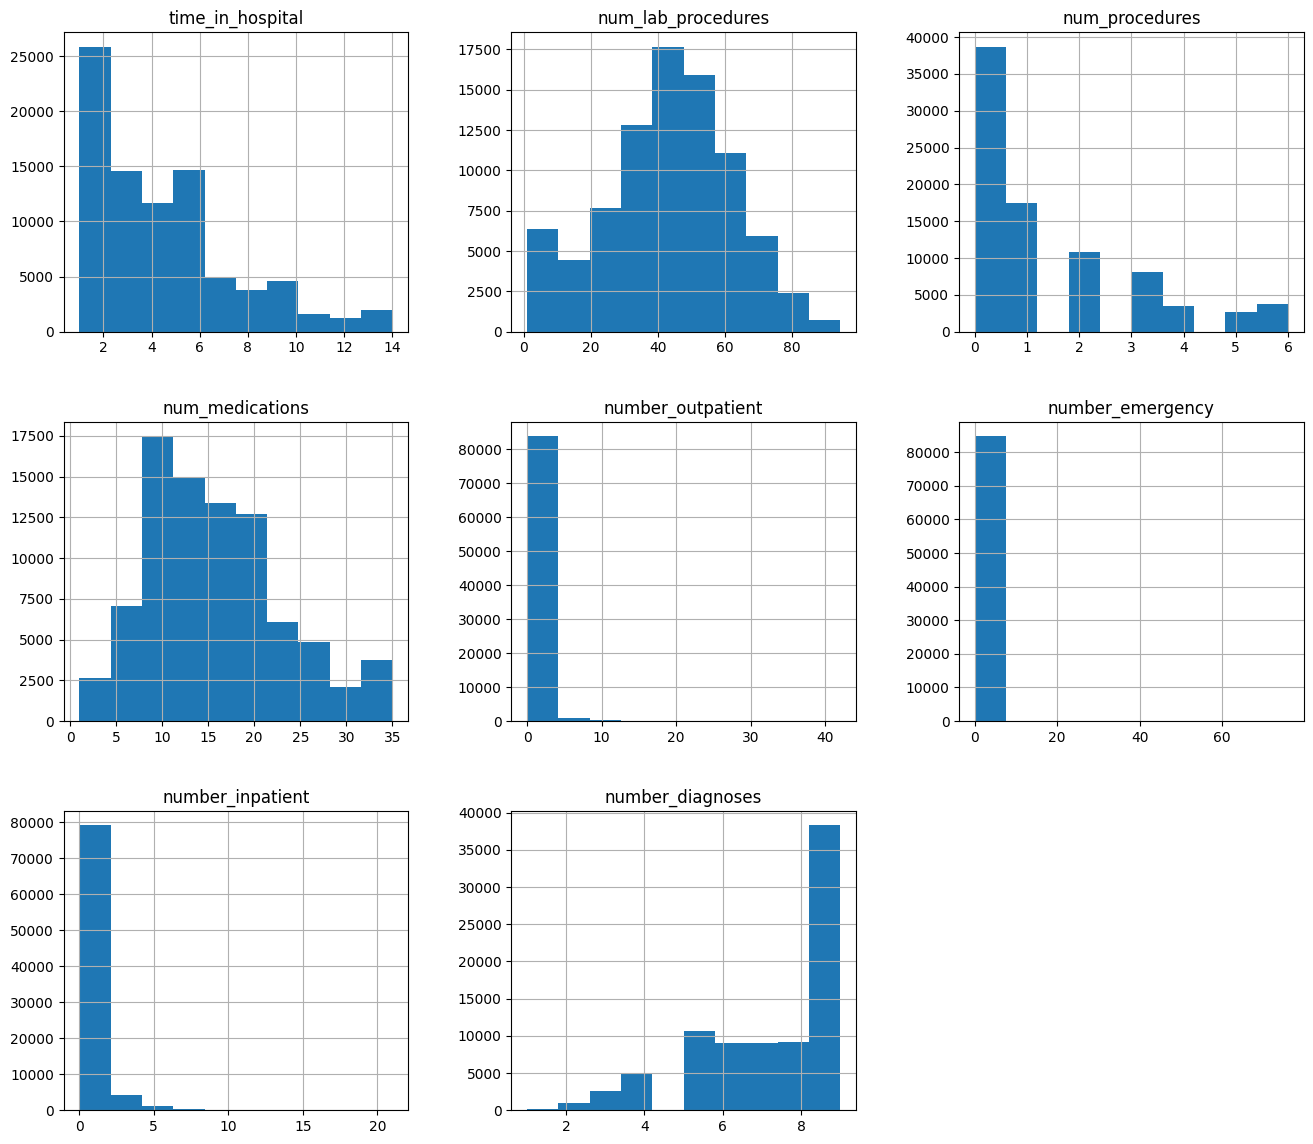

In [131]:
## Let's see distrbution of numerical variables
num_cols = data.select_dtypes(include=['int', 'float']).columns
data[num_cols[2:]].hist(figsize=(16, 14))
plt.show()

In [132]:
# Log Transformation to treat extreme values in this columns
data['number_outpatient_log'] = np.log1p(data['number_outpatient'])
data['number_inpatient_log'] = np.log1p(data['number_inpatient'])
data['number_emergency_log'] = np.log1p(data['number_emergency'])


In [133]:
# ## Let's see distrbution of numerical variables
# num_cols = data.select_dtypes(include=['int', 'float']).columns
# data[num_cols[2:]].hist(figsize=(16, 14))
# plt.show()

In [134]:
data.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide_metformin', 'glipizide_metformin',
       'glimepiride_pioglitazone', 'metformin_rosiglitazone',
       'metformin_pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'admission_source_des', 'admission_type_desc',
       'discharge_desposition_desc', 'discharge_category',
       'admission_category', 'Specialty_Group', 'payer_code_group',
       'number_outpatient_log', 'number_inpatient_log',
  

In [135]:
data.drop(columns={'number_outpatient', 'number_inpatient', 'number_emergency'}, inplace=True)

In [136]:
data.describe()

,encounter_id,patient_nbr,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,number_outpatient_log,number_inpatient_log,number_emergency_log
count,8.500000e+04,8.500000e+04,85000.000000,85000.000000,85000.000000,85000.000000,85000.000000,85000.000000,85000.000000,85000.000000
mean,1.304736e+08,4.882462e+07,4.451612,43.289471,1.334894,15.645718,7.279941,0.161555,0.324850,0.093347
std,6.857767e+07,3.546755e+07,3.015638,19.229168,1.687531,7.382708,1.959969,0.416290,0.509695,0.300716
min,1.252200e+04,1.350000e+02,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,7.414607e+07,2.000563e+07,2.000000,32.000000,0.000000,10.000000,6.000000,0.000000,0.000000,0.000000
50%,1.310813e+08,4.240574e+07,4.000000,44.000000,1.000000,15.000000,8.000000,0.000000,0.000000,0.000000
75%,1.774056e+08,8.487709e+07,6.000000,57.000000,2.000000,20.000000,9.000000,0.000000,0.693147,0.000000
max,2.687621e+08,1.152185e+08,14.000000,94.500000,6.000000,35.000000,9.000000,3.761200,3.091042,4.343805


In [137]:
data['weight'].value_counts()

weight
?            82268
[75-100)      1153
[50-75)        781
[100-125)      518
[125-150)      115
[25-50)         82
[0-25)          46
[150-175)       27
[175-200)        8
>200             2
Name: count, dtype: int64

In [138]:
# Since >90% data has null values will drop this column
del data['weight']

# Data Preprocessing

In [139]:
# Checking for unique values in categorical columns
categorical_columns = data.select_dtypes(include=['object']).columns
print(len(categorical_columns))
for col in categorical_columns:
    print(f"{col}: {data[col].unique()}")


39
race: ['Caucasian' 'AfricanAmerican' 'Other' 'Asian' 'Hispanic']
gender: ['Female' 'Male']
age: ['[80-90)' '[90-100)' '[40-50)' '[50-60)' '[60-70)' '[70-80)' '[20-30)'
 '[10-20)' '[30-40)' '[0-10)']
diag_1: ['398' '434' '197' '250.7' '414' '157' '428' '518' '648' '999' '410' '682'
 '402' '737' '276' '572' 'V57' '189' '786' '427' '996' '277' '584' '462'
 '473' '411' '174' '486' '998' '511' '432' '626' '295' '8' '196' '250.6'
 '618' '182' '845' '423' '808' '250.4' '722' '403' '250.11' '784' '707'
 '440' '151' '715' '997' '198' '564' '812' '38' '590' '556' '578' '250.32'
 '433' 'V58' '569' '185' '536' '255' '250.13' '599' '558' '574' '250.83'
 '491' '560' '244' '250.03' '577' '730' '188' '824' '250.8' '332' '562'
 '291' '296' '510' '401' '263' '438' '70' '250.02' '493' '642' '625' '571'
 '738' '593' '250.42' '807' '456' '446' '575' '250.41' '820' '515' '780'
 '250.22' '995' '235' '250.82' '721' '787' '162' '724' '282' '514' 'V55'
 '281' '250.33' '530' '466' '435' '250.12' 'V53' '789' '

In [140]:
#  dropping 'discharge_desposition_desc','admission_source_des' as we have mapped those with different categories and metformin_rosiglitazone, metformin_pioglitazone as it has only one category no use in our model
data.drop(columns={'metformin_rosiglitazone','metformin_pioglitazone'
                   ,'discharge_desposition_desc','admission_source_des' }, inplace=True)

In [141]:
data['discharge_category'].value_counts()

discharge_category
Discharged to Home                          60599
Transfers to Other Healthcare Facilities    17213
Other                                        4688
Expired                                      1420
Hospice Care                                  563
AMA (Against Medical Advice)                  517
Name: count, dtype: int64

In [142]:
## As Expired and hospice care patients not going to readmit so will drop those records from our data
data = data[~data['discharge_category'].isin(['Expired', 'Hospice Care'])]

In [143]:
data.shape

(83017, 45)

In [144]:
# Check for unique values in categorical columns
categorical_columns = data.select_dtypes(include=['object']).columns
print(len(categorical_columns))
for col in categorical_columns:
    print(f"{col}: {data[col].unique()}")


35
race: ['Caucasian' 'AfricanAmerican' 'Other' 'Asian' 'Hispanic']
gender: ['Female' 'Male']
age: ['[80-90)' '[90-100)' '[40-50)' '[50-60)' '[60-70)' '[70-80)' '[20-30)'
 '[10-20)' '[30-40)' '[0-10)']
diag_1: ['398' '434' '197' '250.7' '414' '157' '428' '518' '648' '999' '410' '682'
 '402' '737' '276' '572' 'V57' '189' '786' '427' '996' '277' '584' '462'
 '473' '411' '174' '486' '998' '511' '626' '295' '8' '196' '250.6' '618'
 '182' '845' '423' '808' '250.4' '722' '250.11' '784' '707' '440' '151'
 '715' '198' '564' '812' '997' '403' '38' '590' '556' '578' '250.32' '433'
 'V58' '569' '185' '536' '255' '250.13' '599' '558' '574' '250.83' '491'
 '560' '244' '250.03' '577' '730' '188' '824' '250.8' '332' '562' '291'
 '296' '510' '401' '263' '438' '70' '250.02' '493' '642' '625' '571' '738'
 '593' '250.42' '807' '456' '446' '575' '250.41' '820' '515' '780'
 '250.22' '995' '235' '250.82' '721' '787' '724' '282' '514' 'V55' '281'
 '250.33' '530' '466' '435' '250.12' 'V53' '789' '566' '822' '

In [145]:
# Function to clean the age column using regex
def clean_age_column(age_series):
    return age_series.str.replace(r'[\[\]() ]', '', regex=True)

# Cleaning the age column
data['age'] = clean_age_column(data['age'])
data.head()

,encounter_id,patient_nbr,race,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,change,diabetesMed,readmitted,admission_type_desc,discharge_category,admission_category,Specialty_Group,payer_code_group,number_outpatient_log,number_inpatient_log,number_emergency_log
0,12522,48330783,Caucasian,Female,80-90,13,68.0,2,28.0,398,427,38,8,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,Steady,No,No,No,Ch,Yes,NO,Urgent,Discharged to Home,Transfers from Other Facilities,Other,Self-Pay/Other,0.0,0.0,0.0
1,15738,63555939,Caucasian,Female,90-100,12,33.0,3,18.0,434,198,486,8,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,Steady,No,No,No,Ch,Yes,NO,Elective,Transfers to Other Healthcare Facilities,Transfers from Other Facilities,Other,Self-Pay/Other,0.0,0.0,0.0
2,16680,42519267,Caucasian,Male,40-50,1,51.0,0,8.0,197,157,250,5,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,Steady,No,No,No,Ch,Yes,NO,Emergency,Discharged to Home,Emergency Admission,Other,Self-Pay/Other,0.0,0.0,0.0
3,28236,89869032,AfricanAmerican,Female,40-50,9,47.0,2,17.0,250.7,403,996,9,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,Yes,YES,Emergency,Discharged to Home,Emergency Admission,Other,Self-Pay/Other,0.0,0.0,0.0
4,35754,82637451,Caucasian,Male,50-60,3,31.0,6,16.0,414,411,250,9,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,Yes,YES,Urgent,Discharged to Home,Physician Referral,Other,Self-Pay/Other,0.0,0.0,0.0


In [146]:
# Convert the target variable to binary (0 for NO, 1 for YES)
data['readmitted'] = data['readmitted'].map({'NO': 0, 'YES': 1})

In [147]:
data['metformin'].value_counts()

metformin
No        66767
Steady    14866
Up          905
Down        479
Name: count, dtype: int64

In [148]:
data['discharge_category'].value_counts()

discharge_category
Discharged to Home                          60599
Transfers to Other Healthcare Facilities    17213
Other                                        4688
AMA (Against Medical Advice)                  517
Name: count, dtype: int64

In [75]:
data.head()

,encounter_id,patient_nbr,race,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,change,diabetesMed,readmitted,admission_type_desc,discharge_category,admission_category,Specialty_Group,payer_code_group,number_outpatient_log,number_inpatient_log,number_emergency_log
0,12522,48330783,Caucasian,Female,80-90,13,68.0,2,28.0,398,427,38,8,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,Steady,No,No,No,Ch,Yes,0,Urgent,Discharged to Home,Transfers from Other Facilities,Other,Self-Pay/Other,0.0,0.0,0.0
1,15738,63555939,Caucasian,Female,90-100,12,33.0,3,18.0,434,198,486,8,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,Steady,No,No,No,Ch,Yes,0,Elective,Transfers to Other Healthcare Facilities,Transfers from Other Facilities,Other,Self-Pay/Other,0.0,0.0,0.0
2,16680,42519267,Caucasian,Male,40-50,1,51.0,0,8.0,197,157,250,5,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,Steady,No,No,No,Ch,Yes,0,Emergency,Discharged to Home,Emergency Admission,Other,Self-Pay/Other,0.0,0.0,0.0
3,28236,89869032,AfricanAmerican,Female,40-50,9,47.0,2,17.0,250.7,403,996,9,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,Yes,1,Emergency,Discharged to Home,Emergency Admission,Other,Self-Pay/Other,0.0,0.0,0.0
4,35754,82637451,Caucasian,Male,50-60,3,31.0,6,16.0,414,411,250,9,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,Yes,1,Urgent,Discharged to Home,Physician Referral,Other,Self-Pay/Other,0.0,0.0,0.0


In [77]:
# data.to_csv('../data/interim/data_for_eda.csv')

In [153]:
# function to map ICD-9 codes to categories
def map_icd_category(code):
    if pd.isna(code):
        return 'Other'
   
    code_str = str(code).split('.')[0]  
   
    # Handling non-numeric ICD-9 codes starting with 'E' or 'V'
    if code_str.startswith('E') or code_str.startswith('V'):
        return 'Other'
   
    try:
        code = int(code_str) 
    except ValueError:
        return 'Other'  
   
    # Map numeric ICD-9 codes to categories
    if 390 <= code <= 459 or code == 785:
        return 'Circulatory'
    elif 460 <= code <= 519 or code == 786:
        return 'Respiratory'
    elif 520 <= code <= 579 or code == 787:
        return 'Digestive'
    elif code == 250:
        return 'Diabetes'
    elif 800 <= code <= 999:
        return 'Injury'
    elif 710 <= code <= 739:
        return 'Musculoskeletal'
    elif 580 <= code <= 629 or code == 788:
        return 'Genitourinary'
    elif 140 <= code <= 239:
        return 'Neoplasms'
    elif (780 <= code <= 799) or (240 <= code <= 279 and code != 250) or \
         (680 <= code <= 709) or (1 <= code <= 139) or (290 <= code <= 319) or \
         (code in range(280, 290)) or (code in range(320, 360)) or \
         (code in range(360, 390)) or (code in range(740, 760)):
        return 'Other'
    else:
        return 'Other'
 
# Apply mapping function to diag_3 only because in diag_3 mazimum no. of patients were diagnose with diabetes out of 1,2,3 diag, also highest no. of readmission found in diag_3
data['diag_3_cat'] = data['diag_3'].apply(map_icd_category)
 

In [154]:
data['diag_3_cat'].value_counts()

diag_3_cat
Other              24956
Circulatory        24666
Diabetes           14631
Respiratory         5968
Genitourinary       5334
Digestive           3100
Musculoskeletal     1525
Injury              1485
Neoplasms           1352
Name: count, dtype: int64

In [156]:
## Dropping other diagnosis columns as no longer neeeded
data.drop(columns={'diag_1', 'diag_2', 'diag_3'}, inplace=True)

In [157]:
data.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide_metformin', 'glipizide_metformin',
       'glimepiride_pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'admission_type_desc', 'discharge_category', 'admission_category',
       'Specialty_Group', 'payer_code_group', 'number_outpatient_log',
       'number_inpatient_log', 'number_emergency_log', 'diag_3_cat'],
      dtype='object')

In [158]:
# Handle medication changes
med_change_mapping = {
    'No': 0,
    'Steady': 1,
    'Up': 2,
    'Down': -1  
}
 
med_cols = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
            'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
            'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide_metformin',
            'glipizide_metformin', 'glimepiride_pioglitazone']
 
for col in med_cols:
    if col in data.columns:
        data[col] = data[col].map(med_change_mapping).fillna(0)  

In [221]:
# med_cols = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
#             'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
#             'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide_metformin',
#             'glipizide_metformin', 'glimepiride_pioglitazone']

In [159]:
#will go ahead with only metmorfin, insulin as in EDA get cleared those 2 drugs inclined towards readmission of patients
#Metformin: First-line therapy for Type 2 diabetes, widely prescribed due to its effectiveness in lowering blood glucose and improving insulin sensitivity.
#Insulin: Essential for patients with advanced Type 2 diabetes or Type 1 diabetes. It's critical to understand how insulin usage correlates with patient outcomes since improper use or mismanagement can lead to readmissions due to either hyperglycemia or hypoglycemia.

data.drop(columns={'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
            'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
            'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'glyburide_metformin',
            'glipizide_metformin', 'glimepiride_pioglitazone'}, inplace=True)

In [213]:
# med_cols

In [160]:
data.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'insulin', 'change', 'diabetesMed', 'readmitted',
       'admission_type_desc', 'discharge_category', 'admission_category',
       'Specialty_Group', 'payer_code_group', 'number_outpatient_log',
       'number_inpatient_log', 'number_emergency_log', 'diag_3_cat'],
      dtype='object')

In [164]:
# Age processing
data['age'].unique()

array(['80-90', '90-100', '40-50', '50-60', '60-70', '70-80', '20-30',
       '10-20', '30-40', '0-10'], dtype=object)

In [168]:
# to make age column numerical will insert random number between that range
#mapping
age_ranges = {
    '0-10': (0, 10),
    '10-20': (10, 20),
    '20-30': (20, 30),
    '30-40': (30, 40),
    '40-50': (40, 50),
    '50-60': (50, 60),
    '60-70': (60, 70),
    '70-80': (70, 80),
    '80-90': (80, 90),
    '90-100': (90, 100)
}
# Function to generate a random number within the age range
def patient_age_treatment(age_group):
    min_age, max_age = age_ranges[age_group]
    return np.random.randint(min_age, max_age + 1)  # +1 to include max_age


In [169]:
data['Patient_Age'] = data['age'].apply(patient_age_treatment)

In [170]:
del data['age']

In [171]:
len(data.columns)

26

In [172]:
data.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'insulin', 'change', 'diabetesMed', 'readmitted', 'admission_type_desc',
       'discharge_category', 'admission_category', 'Specialty_Group',
       'payer_code_group', 'number_outpatient_log', 'number_inpatient_log',
       'number_emergency_log', 'diag_3_cat', 'Patient_Age'],
      dtype='object')

In [174]:
data.select_dtypes(include='object').columns

Index(['race', 'gender', 'max_glu_serum', 'A1Cresult', 'change', 'diabetesMed',
       'admission_type_desc', 'discharge_category', 'admission_category',
       'Specialty_Group', 'payer_code_group', 'diag_3_cat'],
      dtype='object')

In [173]:
data.head()

,encounter_id,patient_nbr,race,gender,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,max_glu_serum,A1Cresult,metformin,insulin,change,diabetesMed,readmitted,admission_type_desc,discharge_category,admission_category,Specialty_Group,payer_code_group,number_outpatient_log,number_inpatient_log,number_emergency_log,diag_3_cat,Patient_Age
0,12522,48330783,Caucasian,Female,13,68.0,2,28.0,8,No,No,0,1,Ch,Yes,0,Urgent,Discharged to Home,Transfers from Other Facilities,Other,Self-Pay/Other,0.0,0.0,0.0,Other,90
1,15738,63555939,Caucasian,Female,12,33.0,3,18.0,8,No,No,0,1,Ch,Yes,0,Elective,Transfers to Other Healthcare Facilities,Transfers from Other Facilities,Other,Self-Pay/Other,0.0,0.0,0.0,Respiratory,92
2,16680,42519267,Caucasian,Male,1,51.0,0,8.0,5,No,No,0,1,Ch,Yes,0,Emergency,Discharged to Home,Emergency Admission,Other,Self-Pay/Other,0.0,0.0,0.0,Diabetes,47
3,28236,89869032,AfricanAmerican,Female,9,47.0,2,17.0,9,No,No,0,1,No,Yes,1,Emergency,Discharged to Home,Emergency Admission,Other,Self-Pay/Other,0.0,0.0,0.0,Injury,45
4,35754,82637451,Caucasian,Male,3,31.0,6,16.0,9,No,No,0,1,No,Yes,1,Urgent,Discharged to Home,Physician Referral,Other,Self-Pay/Other,0.0,0.0,0.0,Diabetes,52


In [175]:
data.to_csv('../data/interim/Final_data_train_test.csv')

In [176]:
data.shape

(83017, 26)

In [155]:
# # Calculate the total count of events (YES) and non-events (NO)
# total_events = data['readmitted'].sum()
# total_non_events = data['readmitted'].count() - total_events


In [110]:
# # Calculate WoE and IV
# def calculate_woe_iv(df, feature, target):
#     # Create a dataframe to hold the counts
#     woe_iv = pd.DataFrame()
    
#     # Group by the feature and calculate the count of events and non-events
#     woe_iv['total'] = df.groupby(feature)[target].count()
#     woe_iv['events'] = df.groupby(feature)[target].sum()
#     woe_iv['non_events'] = woe_iv['total'] - woe_iv['events']
    
#     # Calculate event and non-event rates
#     woe_iv['event_rate'] = woe_iv['events'] / total_events
#     woe_iv['non_event_rate'] = woe_iv['non_events'] / total_non_events
    
#     # Calculate WoE
#     woe_iv['woe'] = np.log(woe_iv['event_rate'] / woe_iv['non_event_rate'])
    
#     # Calculate IV
#     woe_iv['iv'] = (woe_iv['event_rate'] - woe_iv['non_event_rate']) * woe_iv['woe']
    
#     # Return the DataFrame with WoE and IV
#     return woe_iv

In [111]:
# # Calculate WoE and IV for the payer_code column
# woe_iv_results = calculate_woe_iv(data, 'payer_code', 'readmitted')

# # Display results
# woe_iv_results


In [112]:
# # Calculate total IV
# total_iv = woe_iv_results['iv'].sum()
# print(f'Total IV for payer_code: {total_iv}')

In [113]:
# # Calculate WoE and IV for the age column
# woe_iv_results_age = calculate_woe_iv(data, 'age', 'readmitted')


In [114]:
# woe_iv_results_age

In [115]:
# # Create a mapping dictionary from payer_code to WoE values
# woe_mapping = woe_iv_results_age['woe'].to_dict()

# # Replace the original payer_code values with their corresponding WoE values
# data['age_woe'] = data['age'].map(woe_mapping)

# # Check the updated DataFrame
# data[['age', 'age_woe']].head()

In [116]:
# woe_iv_results_discharge_category = calculate_woe_iv(data, 'discharge_category', 'readmitted')
# woe_iv_results_discharge_category

In [169]:
data.shape


(85000, 39)